In [55]:
import os
import shutil
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import trange
from torchvision.transforms import Grayscale
import matplotlib.pyplot as plt


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 567
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)


#"/Users/quentin/Desktop/ML_MRIqc_DATASET/Ready_Data"
data_transforms = {
    "train": transforms.Compose([
        Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.Resize((224, 224)),  # Resize images to VGG16-compatible dimensions (just to keep it consistent with the future)
        transforms.RandomHorizontalFlip(),  # Augmentation
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize([0.5], [0.5])  # Normalize grayscale images
    ]),
    "val": transforms.Compose([
        Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    "test": transforms.Compose([
        Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

data_dir = "/Users/quentin/Desktop/ML_MRIqc_DATASET/Ready_Data"
datasets = {
    x: ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ["train", "val", "test"]
}
dataloaders = {
    x: DataLoader(datasets[x], batch_size=64, shuffle=True, num_workers=4) # Try smaller batch sizes [8,16]
    for x in ["train", "val", "test"]
}

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

# Create 2-CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Dynamically calculate the flattened size
        flattened_size = self._calculate_flattened_size()
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 128)  # Input size matches flattened output
        self.fc2 = nn.Linear(128, 2)  # Accept or reject
    
    def _calculate_flattened_size(self):
        # Use a dummy tensor to determine the flattened size
        dummy_input = torch.zeros(1, 1, 224, 224)  # Single grayscale image with size 224x224
        x = self.conv1(dummy_input)
        x = self.conv2(x)
        return x.numel()  # Flattened size

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x

model = CNN().to(DEVICE)

# Try AdaGrad optimizer with normal x-entropy loss
optimizer = optim.Adagrad(model.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(loader, model, device, optimizer, criterion, log_interval, epoch):
    model.train()
    total_loss = 0
    correct = 0
    losses = []
    counter = []

    for i, (img, label) in enumerate(loader):
        img, label = img.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()
        
        if (i + 1) % log_interval == 0:
            losses.append(loss.item())
            counter.append((i * loader.batch_size) + len(img) + epoch * len(loader.dataset))

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)

    return avg_loss, accuracy, losses, counter

def evaluate(loader, model, device, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for img, label in loader:
            img, label = img.to(device), label.to(device)
            output = model(img)
            loss = criterion(output, label)
            total_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=False)
            correct += pred.eq(label).sum().item()

            predictions.extend(pred.cpu().numpy())
            true_labels.extend(label.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy, predictions, true_labels

print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [57]:
# train loop
max_epochs = 20
patience = 2 # Early stopping (i.e. loss doesn't improve for patience # of epochs)
best_val_loss = float('inf')
p_counter = 0
log_interval = 7

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
log_losses = []
log_counter = []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    # Train
    train_loss, train_accuracy, train_log_loss, train_log_counter = train_one_epoch(train_loader, model, DEVICE, optimizer, criterion, log_interval, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    log_losses.extend(train_log_loss)  # log losses
    log_counter.extend(train_log_counter)  # log counters

    # Validate
    val_loss, val_accuracy,val_pred, val_labels = evaluate(val_loader, model, DEVICE, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_2CNN.pth")  # Save the best model
        p_counter = 0  # Reset patience counter
    else:
        p_counter += 1
        if p_counter >= patience:
            print(f"Early stopping triggered! TOTAL EPOCHS = {epoch}")
            break

Epochs:   5%|█▊                                  | 1/20 [01:39<31:21, 99.00s/it]

Epoch 1:
Train Loss: 0.6608, Train Accuracy: 0.6146
Val Loss: 0.6311, Val Accuracy: 0.6331


Epochs:  10%|███▌                                | 2/20 [03:14<29:02, 96.80s/it]

Epoch 2:
Train Loss: 0.6091, Train Accuracy: 0.6590
Val Loss: 0.6137, Val Accuracy: 0.6511


Epochs:  15%|█████▍                              | 3/20 [04:48<27:09, 95.83s/it]

Epoch 3:
Train Loss: 0.5849, Train Accuracy: 0.6896
Val Loss: 0.5998, Val Accuracy: 0.6727


Epochs:  20%|███████▏                            | 4/20 [06:29<26:01, 97.58s/it]

Epoch 4:
Train Loss: 0.5688, Train Accuracy: 0.7201
Val Loss: 0.5815, Val Accuracy: 0.6799


Epochs:  25%|█████████                           | 5/20 [08:06<24:23, 97.57s/it]

Epoch 5:
Train Loss: 0.5540, Train Accuracy: 0.7237
Val Loss: 0.5623, Val Accuracy: 0.7194


Epochs:  30%|██████████▊                         | 6/20 [09:37<22:11, 95.09s/it]

Epoch 6:
Train Loss: 0.5437, Train Accuracy: 0.7516
Val Loss: 0.5560, Val Accuracy: 0.6942


Epochs:  35%|████████████▌                       | 7/20 [11:14<20:45, 95.83s/it]

Epoch 7:
Train Loss: 0.5318, Train Accuracy: 0.7520
Val Loss: 0.5598, Val Accuracy: 0.7230


Epochs:  40%|██████████████▍                     | 8/20 [12:49<19:07, 95.63s/it]

Epoch 8:
Train Loss: 0.5206, Train Accuracy: 0.7691
Val Loss: 0.5369, Val Accuracy: 0.7446


Epochs:  45%|████████████████▏                   | 9/20 [14:25<17:34, 95.87s/it]

Epoch 9:
Train Loss: 0.5089, Train Accuracy: 0.7727
Val Loss: 0.5302, Val Accuracy: 0.7626


Epochs:  50%|█████████████████▌                 | 10/20 [16:02<15:59, 95.98s/it]

Epoch 10:
Train Loss: 0.5003, Train Accuracy: 0.7844
Val Loss: 0.5300, Val Accuracy: 0.7662


Epochs:  55%|███████████████████▎               | 11/20 [17:43<14:38, 97.61s/it]

Epoch 11:
Train Loss: 0.4948, Train Accuracy: 0.7960
Val Loss: 0.5177, Val Accuracy: 0.7626


Epochs:  60%|█████████████████████              | 12/20 [19:19<12:55, 96.99s/it]

Epoch 12:
Train Loss: 0.4874, Train Accuracy: 0.8005
Val Loss: 0.5005, Val Accuracy: 0.7986


Epochs:  65%|██████████████████████▊            | 13/20 [20:53<11:12, 96.06s/it]

Epoch 13:
Train Loss: 0.4786, Train Accuracy: 0.8068
Val Loss: 0.4988, Val Accuracy: 0.8129


Epochs:  70%|████████████████████████▌          | 14/20 [22:28<09:34, 95.80s/it]

Epoch 14:
Train Loss: 0.4726, Train Accuracy: 0.8095
Val Loss: 0.4991, Val Accuracy: 0.8129


Epochs:  75%|██████████████████████████▎        | 15/20 [24:01<07:54, 94.98s/it]

Epoch 15:
Train Loss: 0.4652, Train Accuracy: 0.8176
Val Loss: 0.4850, Val Accuracy: 0.7914


Epochs:  80%|████████████████████████████       | 16/20 [25:25<06:06, 91.75s/it]

Epoch 16:
Train Loss: 0.4598, Train Accuracy: 0.8136
Val Loss: 0.5006, Val Accuracy: 0.8237


Epochs:  85%|█████████████████████████████▊     | 17/20 [26:42<04:22, 87.40s/it]

Epoch 17:
Train Loss: 0.4532, Train Accuracy: 0.8194
Val Loss: 0.4798, Val Accuracy: 0.8273


Epochs:  90%|███████████████████████████████▌   | 18/20 [27:59<02:48, 84.23s/it]

Epoch 18:
Train Loss: 0.4457, Train Accuracy: 0.8324
Val Loss: 0.4524, Val Accuracy: 0.8345


Epochs:  95%|█████████████████████████████████▎ | 19/20 [29:17<01:22, 82.39s/it]

Epoch 19:
Train Loss: 0.4418, Train Accuracy: 0.8243
Val Loss: 0.4696, Val Accuracy: 0.8381


Epochs:  95%|█████████████████████████████████▎ | 19/20 [30:36<01:36, 96.63s/it]

Epoch 20:
Train Loss: 0.4381, Train Accuracy: 0.8248
Val Loss: 0.4833, Val Accuracy: 0.7950
Early stopping triggered! TOTAL EPOCHS = 19


In [31]:
# def matplotlib_imshow(img, one_channel=True):
#     if one_channel:
#         img = img.mean(dim=0)
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     if one_channel:
#         plt.imshow(npimg)#, cmap="Greys")
#     else:
#         plt.imshow(np.transpose(npimg, (1, 2, 0)))

# dataiter = iter(train_loader)
# images, labels = next(dataiter)

# # Create a grid from the images and show them
# img_grid = torchvision.utils.make_grid(images)
# matplotlib_imshow(img_grid, one_channel=True)
# #print('  '.join(classes[labels[j]] for j in range(2)))


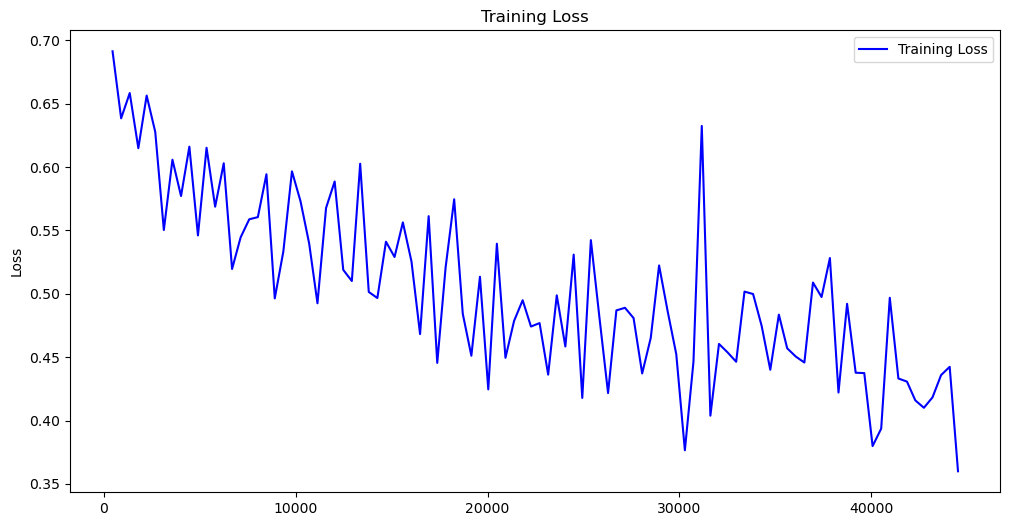

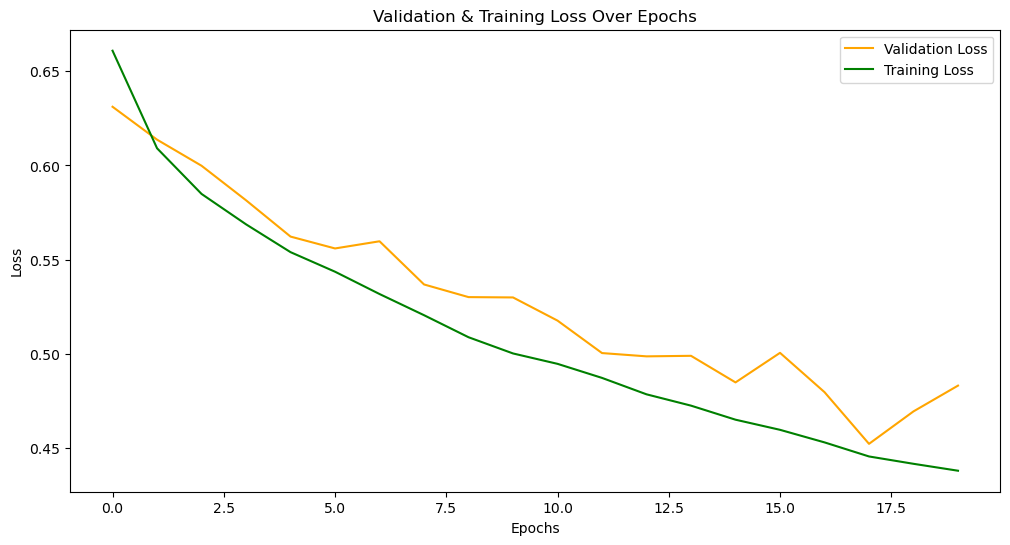

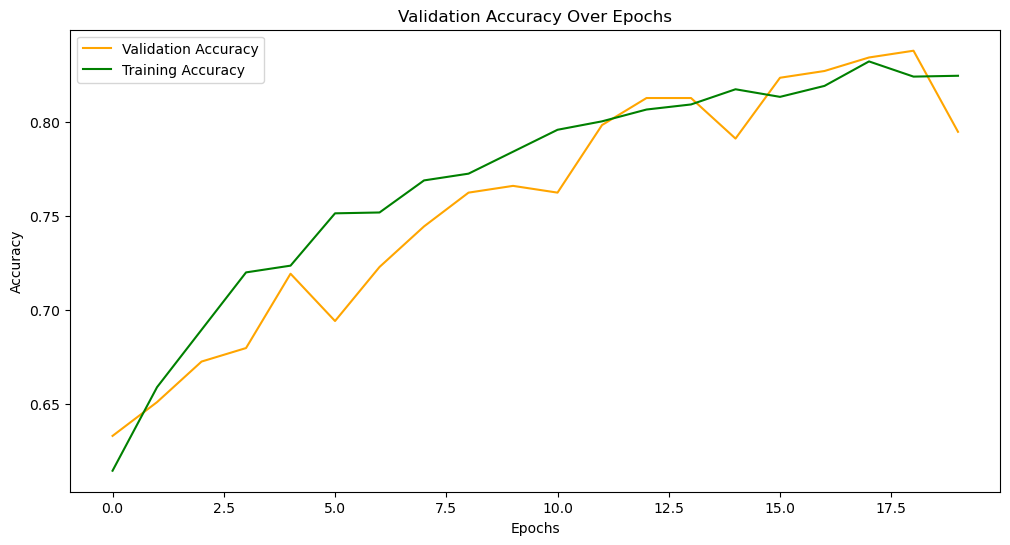

In [59]:
# Plot results
# epoch counter 
plt.figure(figsize=(12, 6))
plt.plot(log_counter, log_losses, color='blue', label='Training Loss')
plt.legend()
plt.title("Training Loss"); plt.ylabel('Loss')

plt.figure(figsize=(12, 6))
plt.plot(range(len(val_losses)), val_losses, color='orange', label='Validation Loss')
plt.plot(range(len(train_losses)), train_losses, color='green', label='Training Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.title("Validation & Training Loss Over Epochs")
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(range(len(val_accuracies)), val_accuracies, color='orange', label='Validation Accuracy')
plt.plot(range(len(train_accuracies)), train_accuracies, color='green', label='Training Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.title("Validation Accuracy Over Epochs")
plt.legend()

plt.show()


In [65]:
import time

start_time = time.time()

# Load the best model before testing
model.load_state_dict(torch.load("best_model_2CNN.pth", weights_only = True))
test_loss, test_accuracy, test_pred, test_labels = evaluate(test_loader, model, DEVICE, criterion)
#test_losses.append(test_loss)
#test_accuracies.append(test_accuracy)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

end_time = time.time()

elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Total training time: {int(minutes)} minutes and {int(seconds)} seconds")


Test Loss: 0.4728, Test Accuracy: 0.7929


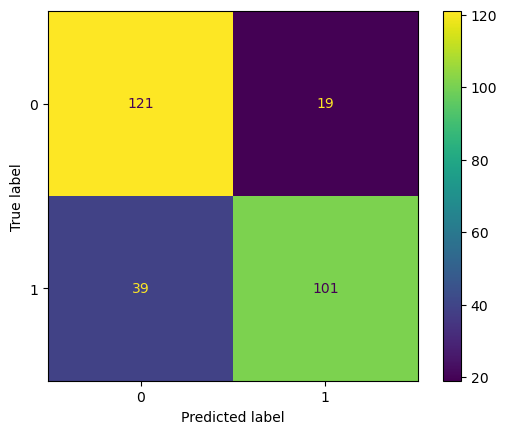

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, test_pred)